# GRU + Attention

## Overview

**This notebook extends the GRU Classifier model (movie watching) described in the [paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008943)  by adding an `Attention Layer`**

Attention used here was first presented by Dzmitry Bahdanau, et al. in their paper [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473).


---
## Data

**Data provided is already preprocessed but needs to be converted in model usabale format**

In [1]:
import torch
import pickle
import numpy as np
import torch.nn as nn

In [2]:
with open('HCP_movie_watching.pkl','rb') as f:
    TS = pickle.load(f)
print(TS.keys())

dict_keys(['testretest', 'twomen', 'bridgeville', 'pockets', 'overcome', 'inception', 'socialnet', 'oceans', 'flower', 'hotel', 'garden', 'dreary', 'homealone', 'brokovich', 'starwars'])


### Dataset organization
`TS` is a dictionary with movie names as keys

Value against each key is a numpy array of dimensions `[#participants, #time points, #ROIs]`

Note that the testretest movie appears on all 4 runs for a participant, therefore the value has dimensions `[#runs, #participants, #time points, #ROIs]`

In [3]:
rel = {}
l = 0
for movie_name, ts in TS.items():
    rel[movie_name] = l
    l += 1
    print(movie_name, ts.shape)

testretest (4, 176, 84, 300)
twomen (176, 245, 300)
bridgeville (176, 222, 300)
pockets (176, 189, 300)
overcome (176, 65, 300)
inception (176, 227, 300)
socialnet (176, 260, 300)
oceans (176, 250, 300)
flower (176, 181, 300)
hotel (176, 186, 300)
garden (176, 205, 300)
dreary (176, 143, 300)
homealone (176, 233, 300)
brokovich (176, 231, 300)
starwars (176, 256, 300)


### Padding sequences

To deal with varying `time points`. For data with `time points < seq_length(self defined)` , I have paded them with 0s. For data with `time points > seq_length(self defined)`, I have split the data into 2 section first, into `[ : seq_length]`, second into `[data_time_point-seq_length : ]`. I have used the `seq_length = 198` (average time_point mentioned in the paper).

**Final `features` array is a 2D array, with shape = `(seq_length,300)`.**

The following block shows above mentioned discussion

In [4]:
train_feature = []
test_feature  = []
train_target  = []
test_target   = []
seq_length    = 198

for movie_name, ts in TS.items():
    pep = 0
    if movie_name != "testretest":
        for i in ts:
            pep += 1
            if (pep <= 100):
                if i.shape[0]>seq_length:
                    k = i[:seq_length][:]
                    train_feature.append(k)
                    train_target.append(rel[movie_name])
                    
                    k = i[i.shape[0]-seq_length:][:]
                    train_feature.append(k)
                    train_target.append(rel[movie_name])
                
                elif i.shape[0]<seq_length:
                    k = [[0]*300]*seq_length
                    k[seq_length-i.shape[0]:] = i
                    train_feature.append(k)
                    train_target.append(rel[movie_name])
                else:
                    train_feature.append(i)
                    train_target.append(rel[movie_name])

            else:
                if i.shape[0]>seq_length:
                    k = i[:seq_length][:]
                    test_feature.append(k)
                    test_target.append(rel[movie_name])
                   
                    k = i[i.shape[0]-seq_length:][:]
                    test_feature.append(k)
                    test_target.append(rel[movie_name])
                
                elif i.shape[0]<seq_length:
                    k = [[0]*300]*seq_length
                    k[seq_length-i.shape[0]:] = i
                    test_feature.append(k)
                    test_target.append(rel[movie_name])
                else:
                    test_feature.append(i)
                    test_target.append(rel[movie_name])
        print(pep)
    else:
        for jj in ts:
            pep = 0
            for i in jj:
                pep += 1
                if (pep <= 101):
                    if i.shape[0]>seq_length:
                        k = i[:seq_length][:]
                        train_feature.append(k)
                        train_target.append(rel[movie_name])

                        k = i[i.shape[0]-seq_length:][:]
                        train_feature.append(k)
                        train_target.append(rel[movie_name])

                    elif i.shape[0]<seq_length:
                        k = [[0]*300]*seq_length
                        k[seq_length-i.shape[0]:] = i
                        train_feature.append(k)
                        train_target.append(rel[movie_name])
                    else:
                        train_feature.append(i)
                        train_target.append(rel[movie_name])

                else:
                    if i.shape[0]>seq_length:
                        k = i[:seq_length][:]
                        test_feature.append(k)
                        test_target.append(rel[movie_name])

                        k = i[i.shape[0]-seq_length:][:]
                        test_feature.append(k)
                        test_target.append(rel[movie_name])

                    elif i.shape[0]<seq_length:
                        k = [[0]*300]*seq_length
                        k[seq_length-i.shape[0]:] = i
                        test_feature.append(k)
                        test_target.append(rel[movie_name])
                    else:
                        test_feature.append(i)
                        test_target.append(rel[movie_name])
            print(pep)

176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176


### Training, Validation, Test

With the data in required shape, The following shows the split into training, validation, and test sets.

In [5]:
len(train_feature), len(test_feature)

(2704, 2048)

In [6]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.from_numpy(np.array(train_feature)).float(),torch.from_numpy(np.array(train_target)).float())
test_data  = TensorDataset(torch.from_numpy(np.array(test_feature)).float(),torch.from_numpy(np.array(test_target)).float())

In [7]:
len(train_data),len(test_data)

(2704, 2048)

In [8]:
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 32
valid_data  = 0.25
t_train     = len(train_data)
data_no     = list(range(t_train))
np.random.shuffle(data_no)
split_no    = int(np.ceil(valid_data*t_train))
train,valid = data_no[split_no:],data_no[:split_no]

train_sampler = SubsetRandomSampler(train)
valid_sampler = SubsetRandomSampler(valid)

train_loader  = DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,drop_last=True)
valid_loader  = DataLoader(train_data,sampler=valid_sampler,batch_size=batch_size,drop_last=True)
test_loader   = DataLoader(test_data, batch_size=batch_size,shuffle = True)

In [9]:
len(valid)

676

In [10]:
len(train_loader),len(valid_loader),len(test_loader)

(63, 21, 64)

In [11]:
iter(train_loader).next()[0].shape

torch.Size([32, 198, 300])

In [12]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cuda')

## Models

### Implementing the `Attention(Bahdanau)` Model

Following figures shows the steps involved in: Blue are the parameters

<img src="attn_enc.png">

In [13]:
class Attention(nn.Module):
    
    def __init__(self, hidden_dim):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        self.W = nn.Linear(2*hidden_dim, hidden_dim, bias=False) 
        self.V = nn.Parameter(torch.rand(hidden_dim))
        self.softmax = nn.Softmax(dim = 1)
    
    def forward(self, x_prev, hj):
        ''' 
            PARAMS:           
                hj: prev hidden_state:    [b, n_layers, hidden_dim]                
                x_prev: prev gru layer output: [b, seq_len, hidden_dim] 
            
            RETURN:
                att_weights:    [b, src_seq_len] 
        '''
        
        hj = hj.permute(1, 0, 2)
        batch_size = x_prev.size(0)
        seq_len = x_prev.size(1)
        
        hj = hj[:, -1, :].unsqueeze(1).repeat(1, seq_len, 1)         #[b, seq_len, hidden_dim]
        
        tanh_W_s_h = torch.tanh(self.W(torch.cat((x_prev, hj), dim=2)))  #[b, sseq_len, hidden_dim]
        tanh_W_s_h = tanh_W_s_h.permute(0, 2, 1)       #[b, hidden_dim, seq_len]
        
        V = self.V.repeat(batch_size, 1).unsqueeze(1)  #[b, 1, hidden_dim]
        e = torch.bmm(V, tanh_W_s_h).squeeze(1)        #[b, seq_len]
        
        att_weights = self.softmax(e)              #[b, seq_len]
        
        return att_weights

### `GRU Classifier` Model as described in the [paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008943) with added normalization layers
<img src="gru.png">

In [14]:
class GRU_RNN(nn.Module):

    def __init__(self, input_dim, output_dim,hidden_dim,n_layers,att=True,drop_prob=0.000006):
        super(GRU_RNN, self).__init__()

        self.output_dim = output_dim
        self.n_layers   = n_layers
        self.hidden_dim = hidden_dim
        self.att        = att
        
        self.gru       = nn.GRU(input_dim,hidden_dim,num_layers=n_layers,dropout=drop_prob,batch_first=True)

        
        self.linear    = nn.Linear(hidden_dim,output_dim)
        if att:
            self.attention = Attention(hidden_dim)
            self.linear    = nn.Linear(2*hidden_dim,output_dim)
        self.dropout   = nn.Dropout(0.3)
        self.func      = nn.Softmax(dim = -1)

    def forward(self, input_x, hj, prev_x):
        xi,hi = self.gru(input_x,hj)

        if self.att:
            att_weights = self.attention(prev_x,hj).unsqueeze(1)
            weighted_sum = torch.bmm(att_weights,xi)
            x = torch.cat((weighted_sum.squeeze(1),prev_x[:,-1,:]), dim=1)
        else:
            x = xi[:, -1, :]
        
        x = self.dropout(x)
        x = self.linear(x)
        sig_out = self.func(x)

        return sig_out,hi,xi
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

## Training

In [28]:
def train(epochs,train_loader,net,valid_loader,optimzer,criterion,att=True):
    val_acc = []
    tr_acc = []
    
    clip = 3 # gradient clipping

    net.to(device)
    net.train()
    
    valid_loss_min = np.Inf 
    
    valid_losses = []
    train_losses = []
    prev_x = torch.zeros(batch_size,seq_length,hidden_dim).to(device)
    nn.init.kaiming_uniform_(prev_x)
    
    for e in range(epochs):
        num_correct = 0
        h = net.init_hidden(batch_size)
        prev_x = torch.zeros(batch_size,seq_length,hidden_dim).to(device)
        nn.init.kaiming_uniform_(prev_x)
        train_loss = []
        valid_loss = []
        train_acc  = 0.0
        valid_acc  = 0.0 
        counter = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
            h = h.data
            net.zero_grad()

            output, h, prev_x = net(inputs, h.detach(), prev_x.detach())
            pred = torch.round(output.squeeze()) 
            top_value, top_index = torch.max(pred,1)
            correct_tensor = top_index.eq(labels.float().view_as(top_index))
            correct = np.squeeze(correct_tensor.to('cpu').numpy())
            num_correct += np.sum(correct)


            loss = criterion(output, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()

            train_loss.append(loss.item())
        tr_acc.append(num_correct/((len(train_loader)-1)*batch_size))



        acc = 0.0
        val_h = net.init_hidden(batch_size)
        val_prev_x = torch.zeros(batch_size,seq_length,hidden_dim).to(device)
        nn.init.kaiming_uniform_(val_prev_x)
        val_losses = []
        net.eval()
        num_correct = 0
        v_c = 0
        
        for inputs, labels in valid_loader:
            val_h = val_h.data
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)

            output, val_h, val_prev_x = net(inputs, val_h,val_prev_x)
            
            pred = torch.round(output.squeeze()) 
            top_value, top_index = torch.max(pred,1)
            correct_tensor = top_index.eq(labels.float().view_as(top_index))
            correct = np.squeeze(correct_tensor.to('cpu').numpy())
            num_correct += np.sum(correct)

            val_loss = criterion(output.squeeze(),labels)
            val_losses.append(val_loss.item())
            
            if val_loss.item() <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, val_loss.item()))
                best_epoch = e
                if att:
                    torch.save(net.state_dict(), 'RNN_GRU_Att.pt')
                else:
                    torch.save(net.state_dict(), 'RNN_GRU.pt')
                valid_loss_min = val_loss.item()

        net.train()
        valid_losses.append(np.mean(val_losses))
        train_losses.append(np.mean(train_loss))
        val_acc.append(num_correct/(len(valid_loader)*batch_size))
        print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(e+1,epochs,np.mean(train_loss),np.mean(val_losses)))
    return train_losses,valid_losses,tr_acc,val_acc,best_epoch

In [29]:
epochs     = 55
input_dim  = 300
hidden_dim = 32
output_dim = 15
n_layers   = 2
lr         = 0.006

### Training with Attention Layer

In [30]:
model     = GRU_RNN(input_dim, output_dim, hidden_dim, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print(model)

GRU_RNN(
  (gru): GRU(300, 32, num_layers=2, batch_first=True, dropout=6e-06)
  (linear): Linear(in_features=64, out_features=15, bias=True)
  (attention): Attention(
    (W): Linear(in_features=64, out_features=32, bias=False)
    (softmax): Softmax(dim=1)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (func): Softmax(dim=-1)
)


In [31]:
train_losses,valid_losses,tr_acc,val_acc,best_epoch = train(epochs,train_loader,model,valid_loader,optimizer,criterion)

Validation loss decreased (inf --> 2.457238).  Saving model ...
Validation loss decreased (2.457238 --> 2.373328).  Saving model ...
Epoch: 1/55 	Training Loss: 2.599293 	Validation Loss: 2.524363
Validation loss decreased (2.373328 --> 2.341884).  Saving model ...
Epoch: 2/55 	Training Loss: 2.468103 	Validation Loss: 2.438837
Validation loss decreased (2.341884 --> 2.293653).  Saving model ...
Validation loss decreased (2.293653 --> 2.223446).  Saving model ...
Epoch: 3/55 	Training Loss: 2.405302 	Validation Loss: 2.387956
Validation loss decreased (2.223446 --> 2.222155).  Saving model ...
Epoch: 4/55 	Training Loss: 2.324601 	Validation Loss: 2.307748
Validation loss decreased (2.222155 --> 2.197115).  Saving model ...
Validation loss decreased (2.197115 --> 2.122011).  Saving model ...
Epoch: 5/55 	Training Loss: 2.259597 	Validation Loss: 2.264010
Validation loss decreased (2.122011 --> 2.107618).  Saving model ...
Validation loss decreased (2.107618 --> 2.092265).  Saving model

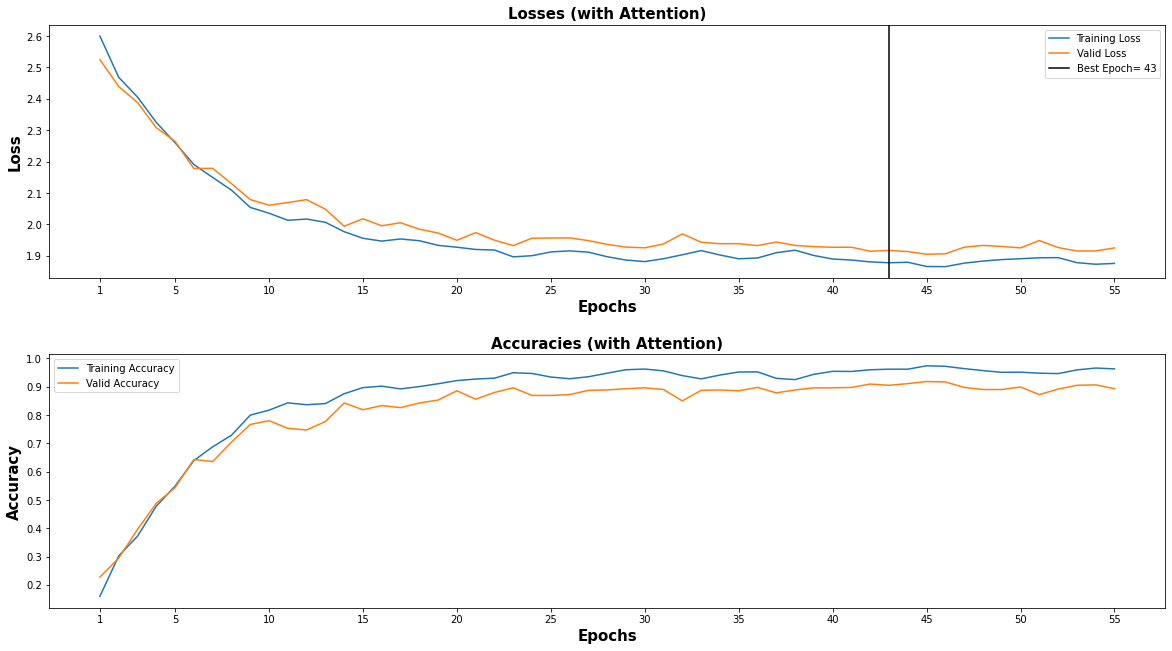

In [32]:
import matplotlib.pyplot as plt
x     = [i for i in range(1,epochs+1)]
xi    = [i for i in range(0,epochs+5,5)]
xi[0] = 1
f, axis = plt.subplots(2,1)
f.set_figwidth(20)
f.set_figheight(12)
plt.subplots_adjust(top=0.8, wspace=0.2,hspace=0.3)

axis[0].plot(x,train_losses)
axis[0].plot(x,valid_losses)
axis[0].axvline(best_epoch, color='black')
axis[0].set_xticks(xi)
axis[0].set_xlabel("Epochs",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis[0].set_ylabel("Loss",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis[0].set_title("Losses (with Attention)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis[0].legend(["Training Loss","Valid Loss",f"Best Epoch= {best_epoch}"])


axis[1].plot(x,tr_acc)
axis[1].plot(x,val_acc)
axis[1].set_xticks(xi)
axis[1].set_xlabel("Epochs", fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis[1].set_ylabel("Accuracy",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis[1].set_title("Accuracies (with Attention)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis[1].legend(["Training Accuracy","Valid Accuracy"]);

### Training without Attention Layer

In [20]:
model     = GRU_RNN(input_dim, output_dim, hidden_dim, n_layers,att=False)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print(model)

GRU_RNN(
  (gru): GRU(300, 32, num_layers=2, batch_first=True, dropout=6e-06)
  (linear): Linear(in_features=32, out_features=15, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (func): Softmax(dim=-1)
)


In [21]:
train_losses_1,valid_losses_1,tr_acc_1,val_acc_1,best_epoch_1= train(epochs,train_loader,model,valid_loader,optimizer,criterion,att=False)

Validation loss decreased (inf --> 2.393660).  Saving model ...
Validation loss decreased (2.393660 --> 2.349475).  Saving model ...
Validation loss decreased (2.349475 --> 2.343988).  Saving model ...
Epoch: 1/55 	Training Loss: 2.547561 	Validation Loss: 2.420918
Validation loss decreased (2.343988 --> 2.285839).  Saving model ...
Validation loss decreased (2.285839 --> 2.205021).  Saving model ...
Validation loss decreased (2.205021 --> 2.162819).  Saving model ...
Validation loss decreased (2.162819 --> 2.143725).  Saving model ...
Epoch: 2/55 	Training Loss: 2.314393 	Validation Loss: 2.283260
Validation loss decreased (2.143725 --> 2.143002).  Saving model ...
Validation loss decreased (2.143002 --> 2.114893).  Saving model ...
Validation loss decreased (2.114893 --> 2.087795).  Saving model ...
Validation loss decreased (2.087795 --> 2.085649).  Saving model ...
Epoch: 3/55 	Training Loss: 2.205447 	Validation Loss: 2.231950
Validation loss decreased (2.085649 --> 2.084089).  Sa

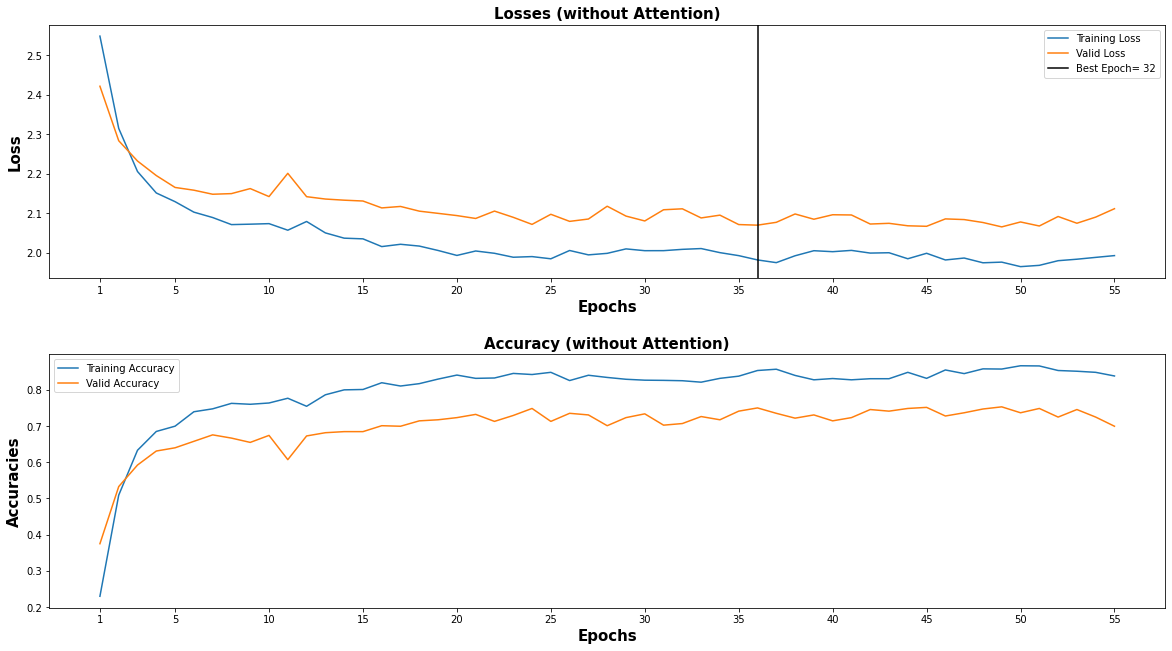

In [22]:
f, axis = plt.subplots(2,1)
f.set_figwidth(20)
f.set_figheight(12)
plt.subplots_adjust(top=0.8, wspace=0.2,hspace=0.3)

axis[0].plot(x,train_losses_1)
axis[0].plot(x,valid_losses_1)
axis[0].axvline(best_epoch, color='black')
axis[0].set_xticks(xi)
axis[0].set_xlabel("Epochs",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis[0].set_ylabel("Loss",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis[0].set_title("Losses (without Attention)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis[0].legend(["Training Loss","Valid Loss",f"Best Epoch= {best_epoch_1}"])


axis[1].plot(x,tr_acc_1)
axis[1].plot(x,val_acc_1)
axis[1].set_xticks(xi)
axis[1].set_xlabel("Epochs", fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis[1].set_ylabel("Accuracies",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis[1].set_title("Accuracy (without Attention)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis[1].legend(["Training Accuracy","Valid Accuracy"]);

## Testing

In [23]:
def test(test_loader,net):
    net.to(device)
    net.eval()
    num_correct = 0
    valid_acc = 0
    h = net.init_hidden(batch_size)
    prev_x = torch.zeros(batch_size,seq_length,hidden_dim).to(device)
    nn.init.kaiming_uniform_(prev_x)
    for inputs, labels in test_loader:
        h = h.data
        inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
        
        output, h,prev_x = net(inputs, h,prev_x)

        pred = torch.round(output.squeeze()) 
        top_value, top_index = torch.max(pred,1)
        correct_tensor = top_index.eq(labels.float().view_as(top_index))
        correct = np.squeeze(correct_tensor.to('cpu').numpy())
        num_correct += np.sum(correct)
    
    test_acc = num_correct/((len(test_loader)-1)*batch_size)
    print("Test accuracy: {:.3f} %".format(test_acc*100))

### Accuracy with Attention Layer

In [33]:
model = GRU_RNN(input_dim, output_dim, hidden_dim, n_layers)
model.load_state_dict(torch.load('RNN_GRU_Att.pt'))

<All keys matched successfully>

In [34]:
test(test_loader,model)

Test accuracy: 91.270 %


### Accuracy without Attention Layer

In [26]:
model = GRU_RNN(input_dim, output_dim, hidden_dim, n_layers,att=False)
model.load_state_dict(torch.load('RNN_GRU.pt'))

<All keys matched successfully>

In [27]:
test(test_loader,model)

Test accuracy: 78.224 %


## Conclusion

Adding an Attention Layer has increased the model accuracy as expected.
The model furthur can be extended/improved by using other methods such as `transformers`